## Temporal phenotyping (Autoencoders)

In [1]:
import numpy as np
from numpy import vstack
import pandas as pd
import pickle
import random
import tqdm
import os

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from pcgrad import PCGrad

import matplotlib.pyplot as plt
%matplotlib inline

from model import OGDTCModel
from dataset import Data
from trainer import train, evaluate

In [2]:
import optuna
import itertools

In [3]:
data_path = 'data/'
DTCR_data_path = 'data/preprocessed_for_DTC/'
save_path = 'results'

In [4]:
torch.cuda.set_device(11)

In [5]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
random.seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
#train phenotying dataset
save_setting = '_train.p'
save_V1 = 'V1'
save_padded_X = 'padded_X'
save_X_lengths = 'X_lengths'
save_outcomes = 'outcomes'

model_name = 'OGDTC.p'

## Load dataset

In [7]:
V1 = pickle.load(open(DTCR_data_path + save_V1 + save_setting, 'rb')) #subjinfo, static
padded_X = pickle.load(open(DTCR_data_path + save_padded_X + save_setting,'rb')) #dynamic
X_lengths = pickle.load(open(DTCR_data_path + save_X_lengths + save_setting,'rb'))
outcomes = pickle.load(open(DTCR_data_path + save_outcomes + save_setting,'rb'))

In [8]:
V1.shape, padded_X.shape

((1569, 36), (1569, 28, 11))

## Set hyperparameters

In [9]:
#input for Vanila setting
batch_size = 64
num_epochs = 400
num_layers = 2
num_clusters = 4
max_sequence_length = padded_X.shape[2]
input_size_V1 = V1.shape[1]
input_size_X = padded_X.shape[1] 
input_size = input_size_V1 + input_size_X 
hidden_size = 32

## Train

In [11]:
# dataset
data = Data(V1, padded_X, X_lengths, outcomes.to_numpy())

# train test split
train_sz=int(len(V1)*0.8)
val_sz=int(len(V1)*0.1)
test_sz=len(V1)-train_sz-val_sz
data_train, data_valid, data_test=random_split(data, [train_sz, val_sz, test_sz],generator=torch.Generator()) 

In [12]:
# dataloader
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(data_valid, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False)

In [13]:
# model, optimizer
model = OGDTCModel(input_size_V1, input_size_X, hidden_size, num_clusters, num_layers).cuda()
criterion_MSE = nn.MSELoss()
optimizer = PCGrad(torch.optim.Adam(model.parameters(),lr=0.0001))

# loss initial
lmbda_kloss = 1 # weight for k-means loss
lmbda_lrloss = 0.1 # weight for regression loss 
min_val_loss = np.Inf
max_val_ss = 0             

train_rloss_list=[]
train_kloss_list=[]
train_lrloss_list=[]
train_loss_list=[]

valid_rloss_list=[]
valid_kloss_list=[]
valid_lrloss_list=[]
valid_loss_list=[]

torch.autograd.set_detect_anomaly(True)
for epoch in range(num_epochs):
    # train step
    model.train()
    loss, rloss, kloss, lrloss = train(model, train_loader, criterion_MSE, optimizer)
    
    if (epoch + 1) % 50 == 0:
        print('**********')
        print(f'Epoch {epoch}')
        print('**********')
        print('Train:') 
        print(f'Loss: {loss:.4f} | RLoss: {rloss:.4f} | KLoss: {kloss:.4f} | LRoss: {lrloss:.4f}')
    
    train_loss_list.append(loss)     
    train_rloss_list.append(rloss) 
    train_kloss_list.append(kloss) 
    train_lrloss_list.append(lrloss) 

    # Validation step
    model.eval()
    loss, rloss, kloss, lrloss, _, _ = evaluate(model, eval_loader, criterion)
    
    if (epoch + 1) % 50 == 0:
        print('**********')
        print('Validation:')
        print(f'Loss: {loss:.4f} | RLoss: {rloss:.4f} | KLoss: {kloss:.4f} | LRoss: {lrloss:.4f}')
        
    valid_loss_list.append(loss) 
    valid_rloss_list.append(rloss) 
    valid_kloss_list.append(kloss) 
    valid_lrloss_list.append(lrloss) 

    if loss < min_val_loss:
        min_val_loss = loss
        torch.save(model.state_dict(), save_path+model_name)
        print('**********')
        print(f'Best validation loss at epoch {epoch+1}')
        print(f'With validation Loss: {loss:.4f}')

del model
torch.cuda.empty_cache() 

**********************************
Best validation loss at epoch 1
With validation Loss: 46.7622
**********************************
Best validation loss at epoch 2
With validation Loss: 44.3396
**********************************
Best validation loss at epoch 3
With validation Loss: 40.7822
**********************************
Best validation loss at epoch 4
With validation Loss: 38.7098
**********************************
Best validation loss at epoch 5
With validation Loss: 36.8635
**********************************
Best validation loss at epoch 6
With validation Loss: 34.8564
**********************************
Best validation loss at epoch 7
With validation Loss: 32.1286
**********************************
Best validation loss at epoch 8
With validation Loss: 31.1019
**********************************
Best validation loss at epoch 9
With validation Loss: 28.4740
**********************************
Best validation loss at epoch 10
With validation Loss: 27.2600
*****************************

**********************************
Best validation loss at epoch 112
With validation Loss: 5.2642
**********************************
Best validation loss at epoch 113
With validation Loss: 5.2251
**********************************
Best validation loss at epoch 114
With validation Loss: 5.2052
**********************************
Best validation loss at epoch 115
With validation Loss: 5.1772
**********************************
Best validation loss at epoch 116
With validation Loss: 5.1462
**********************************
Best validation loss at epoch 118
With validation Loss: 5.0746
**********************************
Best validation loss at epoch 120
With validation Loss: 5.0276
**********************************
Best validation loss at epoch 121
With validation Loss: 5.0070
**********************************
Best validation loss at epoch 122
With validation Loss: 4.9972
**********************************
Best validation loss at epoch 123
With validation Loss: 4.9768
********************

**********************************
Best validation loss at epoch 213
With validation Loss: 3.1391
**********************************
Best validation loss at epoch 214
With validation Loss: 3.1257
**********************************
Best validation loss at epoch 215
With validation Loss: 3.1089
**********************************
Best validation loss at epoch 216
With validation Loss: 3.0920
**********************************
Best validation loss at epoch 217
With validation Loss: 3.0607
**********************************
Best validation loss at epoch 218
With validation Loss: 3.0597
**********************************
Best validation loss at epoch 219
With validation Loss: 3.0314
**********************************
Best validation loss at epoch 222
With validation Loss: 3.0047
**********************************
Best validation loss at epoch 223
With validation Loss: 2.9885
**********************************
Best validation loss at epoch 224
With validation Loss: 2.9821
********************

**********************************
Best validation loss at epoch 325
With validation Loss: 1.8336
**********************************
Best validation loss at epoch 327
With validation Loss: 1.8030
**********************************
Best validation loss at epoch 329
With validation Loss: 1.7995
**********************************
Best validation loss at epoch 330
With validation Loss: 1.7869
**********************************
Best validation loss at epoch 331
With validation Loss: 1.7824
**********************************
Best validation loss at epoch 333
With validation Loss: 1.7612
**********************************
Best validation loss at epoch 334
With validation Loss: 1.7526
**********************************
Best validation loss at epoch 337
With validation Loss: 1.7188
**********************************
Best validation loss at epoch 340
With validation Loss: 1.7107
**********************************
Best validation loss at epoch 341
With validation Loss: 1.6942
********************

In [14]:
print('**********')
print('Test:')
# load the best model
best_model = OGDTCModel(input_size_V1, input_size_X, hidden_size, num_clusters, num_layers).cuda()
path = save_path+model_name
state_dict = torch.load(path)
best_model.load_state_dict(state_dict)

# test on the best model
best_model.eval()
loss, rloss, kloss, lrloss, r2, r2_list = evaluate(model, eval_loader, criterion)

print(f'Loss: {loss:.4f}')
print(f'RLoss: {rloss:.4f}')
print(f'KLoss: {kloss:.4f}')
print(f'LRLoss: {lrloss:.4f}')
print(f'R2score:{r2:.4f}')
print(f'R2_list:{r2_list}')

**********
Test:
Loss: 1.4105
RLoss: 0.6263
KLoss: 0.0367
LRLoss: 0.7475
R2score:0.6001
R2_list:[0.8654496750229695, 0.33468690854922833]


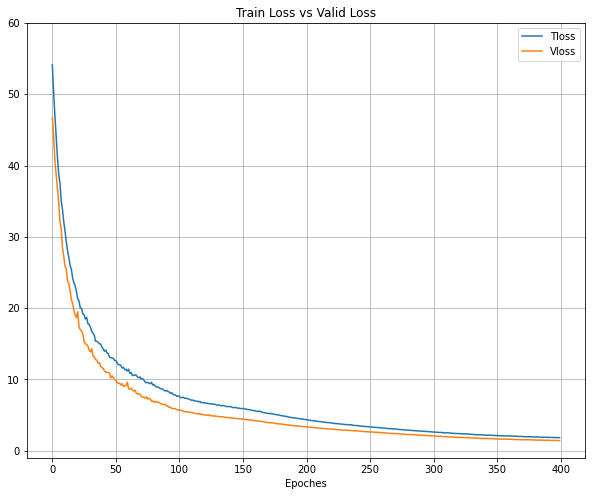

In [15]:
plt.figure(figsize=(10, 8))
plt.plot(train_loss_list)
plt.plot(valid_loss_list)
plt.ylim([-1,60])
plt.title('Train Loss vs Valid Loss')
plt.xlabel('Epoches')
# plt.legend(['Tloss','Taugloss','Trloss','Tkloss','Tfloss','Vloss','Vrloss','Vkloss','Vfloss'])
plt.legend(['Tloss','Vloss'])
plt.grid()
plt.show()